**Import libraries**

In [1]:
import pandas as pd #library for data analysis
import requests #library to handle requests
import numpy as np #library to handle data in a vectorised manner

!pip install geocoder
import geocoder # import geocoder

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium #plotting library

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt #plotting library
#backend for rendering plots within the browser
%matplotlib inline

from sklearn.cluster import KMeans

print("Folium install")
print("Libraries imported")

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium install
Libraries imported


**Read csv to obtain list of MRT stations**

In [2]:
dfmrt = pd.read_csv(r'C:\Users\yuxii\Downloads\train-station-chinese-names.csv')
dfmrt

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North South Line,南北线
4,NS5,Yew Tee,油池,North South Line,南北线
...,...,...,...,...,...
179,PW3,Punggol Point,榜鹅坊,Punggol LRT,榜鹅轻轨线
180,PW4,Samudera,山姆,Punggol LRT,榜鹅轻轨线
181,PW5,Nibong,尼蒙,Punggol LRT,榜鹅轻轨线
182,PW6,Sumang,苏芒,Punggol LRT,榜鹅轻轨线


In [3]:
#Work with stations that are on the main lines and ignore LRT stations
dfmrt = dfmrt[dfmrt['mrt_line_english'].str.contains('Line')]
dfmrt

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North South Line,南北线
4,NS5,Yew Tee,油池,North South Line,南北线
...,...,...,...,...,...
136,DT31,Tampines West,淡滨尼西,Downtown Line,滨海市区线
137,DT32,Tampines,淡滨尼,Downtown Line,滨海市区线
138,DT33,Tampines East,淡滨尼东,Downtown Line,滨海市区线
139,DT34,Upper Changi,樟宜上段,Downtown Line,滨海市区线


In [4]:
#retain only mrt_station_english column, rename column as MRT and drop duplicates
dfmrtlist = dfmrt.copy()
dfmrtlist.drop(columns=['stn_code', 'mrt_station_chinese', 'mrt_line_english', 'mrt_line_chinese'], axis=1, inplace = True)
dfmrtlist.columns=["MRT"]
dfmrtlist

,MRT
0,Jurong East
1,Bukit Batok
2,Bukit Gombak
3,Choa Chu Kang
4,Yew Tee
...,...
136,Tampines West
137,Tampines
138,Tampines East
139,Upper Changi


**Obtain geographical coordinates**

In [5]:
# define a function to get coordinates
def get_latlng(MRT):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(MRT))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [6]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(MRT) for MRT in dfmrtlist["MRT"].tolist()]
coords

[[1.3343700000000354, 103.74367000000007],
 [1.349520000000041, 103.75277000000006],
 [1.3641700000000583, 103.75722000000007],
 [1.3861600000000749, 103.74618000000004],
 [1.3944400000000314, 103.75389000000007],
 [1.429110000000037, 103.75620000000004],
 [1.4411100000000374, 103.77083000000005],
 [1.4358500000000731, 103.78698000000009],
 [1.4406900000000746, 103.80093000000005],
 [1.4479400000000737, 103.81891000000007],
 [1.4362100000000737, 103.83582000000007],
 [1.2904100000000653, 103.85211000000004],
 [1.3879700000000526, 103.86879000000005],
 [1.3716100000000324, 103.84546000000006],
 [1.3507900000000745, 103.85110000000009],
 [1.3433096560276077, 103.85357333378265],
 [1.3344800000000419, 103.85108000000008],
 [1.3191000000000486, 103.84372000000008],
 [1.312180000000069, 103.83912000000004],
 [1.3010900000000447, 103.83965000000006],
 [1.302470000000028, 103.83917000000008],
 [1.2987400000000662, 103.84800000000007],
 [1.2925700000000688, 103.85687000000007],
 [1.28189000000

In [7]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

#merge coordinates into dfmrtlist
dfmrtlist['Latitude'] = df_coords['Latitude']
dfmrtlist['Longitude'] = df_coords['Longitude']

#check the MRT and its coordinate
print(dfmrtlist.shape)
dfmrtlist

(141, 3)


,MRT,Latitude,Longitude
0,Jurong East,1.334370,103.743670
1,Bukit Batok,1.349520,103.752770
2,Bukit Gombak,1.364170,103.757220
3,Choa Chu Kang,1.386160,103.746180
4,Yew Tee,1.394440,103.753890
...,...,...,...
136,Tampines West,1.348690,103.936200
137,Tampines,1.368190,103.929480
138,Tampines East,1.353770,103.954170
139,Upper Changi,1.336607,103.955872


In [8]:
dfmrtlist.drop_duplicates(keep='first', inplace=True)
dfmrtlist

,MRT,Latitude,Longitude
0,Jurong East,1.334370,103.743670
1,Bukit Batok,1.349520,103.752770
2,Bukit Gombak,1.364170,103.757220
3,Choa Chu Kang,1.386160,103.746180
4,Yew Tee,1.394440,103.753890
...,...,...,...
134,Bedok North,1.334450,103.918650
135,Bedok Reservoir,1.342610,103.925390
136,Tampines West,1.348690,103.936200
138,Tampines East,1.353770,103.954170


**Create a map of Singapore showing the MRT stations**

In [127]:
#define Foursquare Credentials and Version

CLIENT_ID = 'your_client_ID'
CLIENT_SECRET = 'your_client_secret'
VERSION = '20180604'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: your_client_ID
CLIENT_SECRET:your_client_secret


In [10]:
#obtain the latitude and longitude of Singapore
address = 'Singapore'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Coordinates of Singapore: ", latitude, longitude)

Coordinates of Singapore:  1.357107 103.8194992


In [11]:
#define the world map around Singapore
sg_map = folium.Map(location=[latitude, longitude],zoom_start = 11)

#add marks to map
for lat, lng, mrt in zip(dfmrtlist['Latitude'], dfmrtlist['Longitude'], dfmrtlist['MRT']):
    label = '{}'.format(mrt)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'yellow',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.6
        ).add_to(sg_map)

#display the map of Singapore
sg_map

**Search for restaurants nearby each MRT stations using Foursquare API**

In [25]:
#search for restaurants within 500 metres from the MRT stations
categoryId = '4d4b7105d754a06374d81259'
radius = 500
LIMIT = 50

venue_columns = ['MRT','MRT Latitude','MRT Longitude','VenueID','VenueName','category','catID','latitude','longitude']
venue_DF = pd.DataFrame(columns=venue_columns)

for lat, lng, mrt in zip(dfmrtlist['Latitude'], dfmrtlist['Longitude'], dfmrtlist['MRT']):

    #define URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        lng, 
        VERSION, 
        radius, 
        LIMIT,
        categoryId)

    #send the GET requests and examine the results
    results = requests.get(url).json()
    
    for venues in results['response']['venues']:
    # JSON Results may not be in expected format or incomplete data, in that case, skip!
        try:
            # If there are any issue with a restaurant, retry or ignore and continue
            # Get location details
            ven_id   = venues['id']
            ven_cat  = venues['categories'][0]['pluralName']
            ven_CID  = venues['categories'][0]['id']
            ven_name = venues['name']
            ven_lat  = venues['location']['lat']
            ven_lng  = venues['location']['lng']
            venue_DF = venue_DF.append({
                'MRT'      : mrt,
                'MRT Latitude' : lat,
                'MRT Longitude': long,
                'VenueID'   : ven_id,
                'VenueName' : ven_name,
                'category'  : ven_cat,
                'catID'     : ven_CID,
                'latitude'  : ven_lat,
                'longitude' : ven_lng}, ignore_index=True)
        except:
            continue
        
venue_DF

,MRT,MRT Latitude,MRT Longitude,VenueID,VenueName,category,catID,latitude,longitude
0,Jurong East,1.334370,103.74367,529a474f498e05f777863f74,Paradise Dynasty 樂天皇朝 (Paradise Dynasty),Chinese Restaurants,4bf58dd8d48988d145941735,1.334364,103.743612
1,Jurong East,1.334370,103.74367,5c1895fcfd9d73002c0d270c,Coffeesmith,Cafés,4bf58dd8d48988d16d941735,1.333960,103.742476
2,Jurong East,1.334370,103.74367,52a9b3ba498e902b40e24937,Sushi Express 争鮮回転寿司,Sushi Restaurants,4bf58dd8d48988d1d2941735,1.334100,103.743187
3,Jurong East,1.334370,103.74367,52a044e2498e1f7ce2462205,KOI Café,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.334148,103.743273
4,Jurong East,1.334370,103.74367,529a59be498e05f7778df360,Tim Ho Wan 添好運 (Tim Ho Wan),Dim Sum Restaurants,4bf58dd8d48988d1f5931735,1.334194,103.743312
...,...,...,...,...,...,...,...,...,...
5282,Upper Changi,1.336607,103.74367,4daa44ce4b22f071eab51980,My Kitchen,Asian Restaurants,4bf58dd8d48988d142941735,1.338111,103.951639
5283,Upper Changi,1.336607,103.74367,55cda1dd498ee6d37e5fc660,Curry Times by Old Chang Kee,Comfort Food Restaurants,52e81612bcbc57f1066b7a00,1.339548,103.953344
5284,Upper Changi,1.336607,103.74367,4d997b3461a3a1cda944e542,Hall 4 Staff Cafe,Cafés,4bf58dd8d48988d16d941735,1.334986,103.959387
5285,Upper Changi,1.336607,103.74367,509739d6e4b0ad0d96cfb889,Atiqa Nasi Padang & Malay Food,Indonesian Restaurants,4deefc054765f83613cdba6f,1.335685,103.950738


In [26]:
venue_DF.groupby(['MRT']).count()

,MRT Latitude,MRT Longitude,VenueID,VenueName,category,catID,latitude,longitude
MRT,,,,,,,,
Admiralty,49,49,49,49,49,49,49,49
Aljunied,48,48,48,48,48,48,48,48
Ang Mo Kio,50,50,50,50,50,50,50,50
Bartley,18,18,18,18,18,18,18,18
Bayfront,50,50,50,50,50,50,50,50
...,...,...,...,...,...,...,...,...
Woodleigh,29,29,29,29,29,29,29,29
Yew Tee,40,40,40,40,40,40,40,40
Yio Chu Kang,41,41,41,41,41,41,41,41


In [27]:
print('There are {} unique categories.'.format(len(venue_DF['category'].unique())))

There are 163 unique categories.


In [28]:
venue_DF['category'].value_counts()

Coffee Shops                      561
Food Courts                       499
Chinese Restaurants               485
Cafés                             415
Asian Restaurants                 283
                                 ... 
Gas Stations                        1
Gluten-free Restaurants             1
Chinese Aristocrat Restaurants      1
Fujian Restaurants                  1
Plazas                              1
Name: category, Length: 163, dtype: int64

In [29]:
venue_DF1 = venue_DF.copy()

In [30]:
venue_DF1

,MRT,MRT Latitude,MRT Longitude,VenueID,VenueName,category,catID,latitude,longitude
0,Jurong East,1.334370,103.74367,529a474f498e05f777863f74,Paradise Dynasty 樂天皇朝 (Paradise Dynasty),Chinese Restaurants,4bf58dd8d48988d145941735,1.334364,103.743612
1,Jurong East,1.334370,103.74367,5c1895fcfd9d73002c0d270c,Coffeesmith,Cafés,4bf58dd8d48988d16d941735,1.333960,103.742476
2,Jurong East,1.334370,103.74367,52a9b3ba498e902b40e24937,Sushi Express 争鮮回転寿司,Sushi Restaurants,4bf58dd8d48988d1d2941735,1.334100,103.743187
3,Jurong East,1.334370,103.74367,52a044e2498e1f7ce2462205,KOI Café,Bubble Tea Shops,52e81612bcbc57f1066b7a0c,1.334148,103.743273
4,Jurong East,1.334370,103.74367,529a59be498e05f7778df360,Tim Ho Wan 添好運 (Tim Ho Wan),Dim Sum Restaurants,4bf58dd8d48988d1f5931735,1.334194,103.743312
...,...,...,...,...,...,...,...,...,...
5282,Upper Changi,1.336607,103.74367,4daa44ce4b22f071eab51980,My Kitchen,Asian Restaurants,4bf58dd8d48988d142941735,1.338111,103.951639
5283,Upper Changi,1.336607,103.74367,55cda1dd498ee6d37e5fc660,Curry Times by Old Chang Kee,Comfort Food Restaurants,52e81612bcbc57f1066b7a00,1.339548,103.953344
5284,Upper Changi,1.336607,103.74367,4d997b3461a3a1cda944e542,Hall 4 Staff Cafe,Cafés,4bf58dd8d48988d16d941735,1.334986,103.959387
5285,Upper Changi,1.336607,103.74367,509739d6e4b0ad0d96cfb889,Atiqa Nasi Padang & Malay Food,Indonesian Restaurants,4deefc054765f83613cdba6f,1.335685,103.950738


**Top 20 food establishments categories**

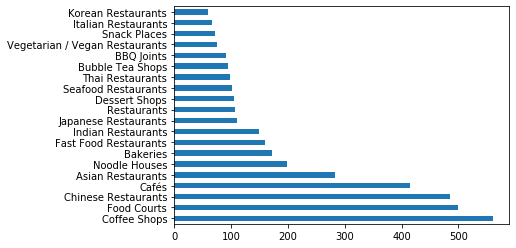

In [106]:
venue_DF['category'].value_counts()[:20].plot(kind='barh')

In [31]:
#one hot encoding
venue_onehot = pd.get_dummies(venue_DF1[['category']], prefix = "", prefix_sep = "")

#add MRT column back to dataframe
venue_onehot['MRT'] = venue_DF1['MRT']

#move MRT column to the first column
fixedcolumns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixedcolumns]

print(venue_onehot.shape)
venue_onehot.head()

(5287, 164)


,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Tapas Restaurants,Tea Rooms,Thai Restaurants,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
venue_group = venue_onehot.groupby(['MRT']).mean().reset_index()

venue_group

,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Tapas Restaurants,Tea Rooms,Thai Restaurants,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints
0,Admiralty,0.0,0.000,0.0,0.000000,0.0,0.061224,0.0,0.000000,0.0,...,0.00,0.00,0.020408,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
1,Aljunied,0.0,0.000,0.0,0.020833,0.0,0.208333,0.0,0.000000,0.0,...,0.00,0.00,0.041667,0.00,0.0,0.0,0.020833,0.00,0.0,0.000000
2,Ang Mo Kio,0.0,0.000,0.0,0.000000,0.0,0.080000,0.0,0.000000,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.020000,0.00,0.0,0.000000
3,Bartley,0.0,0.000,0.0,0.000000,0.0,0.055556,0.0,0.000000,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.055556,0.00,0.0,0.000000
4,Bayfront,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.02,0.04,0.000000,0.02,0.0,0.0,0.000000,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Woodleigh,0.0,0.000,0.0,0.000000,0.0,0.137931,0.0,0.034483,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.034483
114,Yew Tee,0.0,0.025,0.0,0.025000,0.0,0.050000,0.0,0.050000,0.0,...,0.00,0.00,0.025000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
115,Yio Chu Kang,0.0,0.000,0.0,0.048780,0.0,0.048780,0.0,0.000000,0.0,...,0.00,0.00,0.024390,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
116,Yishun,0.0,0.000,0.0,0.000000,0.0,0.020000,0.0,0.020000,0.0,...,0.00,0.00,0.020000,0.00,0.0,0.0,0.060000,0.00,0.0,0.000000


**All Food Establishments: Find optimal k for clustering**

In [34]:
venue_cluster = venue_group.drop(['MRT'], 1)

mms = MinMaxScaler()
mms.fit(venue_cluster)
venue_transformed = mms.transform(venue_cluster)

In [35]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(venue_cluster)
    Sum_of_squared_distances.append(km.inertia_)

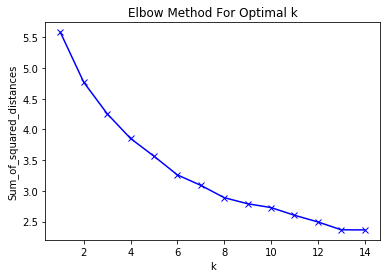

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**All Food Establishments: k-Means clustering**

In [63]:
k = 6

kmeans = KMeans(n_clusters = k, random_state = 0).fit(venue_cluster)

kmeans.labels_[0:10]

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

**All Food Establishments: Add cluster label to dataframe**

In [64]:
venue_group["Cluster Label"] = kmeans.labels_
venue_group.head()

,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Tea Rooms,Thai Restaurants,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label
0,Admiralty,0.0,0.0,0.0,0.000000,0.0,0.061224,0.0,0.0,0.0,...,0.00,0.020408,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,1
1,Aljunied,0.0,0.0,0.0,0.020833,0.0,0.208333,0.0,0.0,0.0,...,0.00,0.041667,0.00,0.0,0.0,0.020833,0.0,0.0,0.0,0
2,Ang Mo Kio,0.0,0.0,0.0,0.000000,0.0,0.080000,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.020000,0.0,0.0,0.0,0
3,Bartley,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.055556,0.0,0.0,0.0,0
4,Bayfront,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.04,0.000000,0.02,0.0,0.0,0.000000,0.0,0.0,0.0,1


In [65]:
venue_group1 = venue_group.copy()
venue_group1

,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Tea Rooms,Thai Restaurants,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label
0,Admiralty,0.0,0.000,0.0,0.000000,0.0,0.061224,0.0,0.000000,0.0,...,0.00,0.020408,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,1
1,Aljunied,0.0,0.000,0.0,0.020833,0.0,0.208333,0.0,0.000000,0.0,...,0.00,0.041667,0.00,0.0,0.0,0.020833,0.00,0.0,0.000000,0
2,Ang Mo Kio,0.0,0.000,0.0,0.000000,0.0,0.080000,0.0,0.000000,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.020000,0.00,0.0,0.000000,0
3,Bartley,0.0,0.000,0.0,0.000000,0.0,0.055556,0.0,0.000000,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.055556,0.00,0.0,0.000000,0
4,Bayfront,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.04,0.000000,0.02,0.0,0.0,0.000000,0.00,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Woodleigh,0.0,0.000,0.0,0.000000,0.0,0.137931,0.0,0.034483,0.0,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.034483,2
114,Yew Tee,0.0,0.025,0.0,0.025000,0.0,0.050000,0.0,0.050000,0.0,...,0.00,0.025000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0
115,Yio Chu Kang,0.0,0.000,0.0,0.048780,0.0,0.048780,0.0,0.000000,0.0,...,0.00,0.024390,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,1
116,Yishun,0.0,0.000,0.0,0.000000,0.0,0.020000,0.0,0.020000,0.0,...,0.00,0.020000,0.00,0.0,0.0,0.060000,0.00,0.0,0.000000,2


**All Food Establishments: Add Latitude and Longitude of MRT**

In [66]:
venue_group1 = venue_group1.join(dfmrtlist.set_index("MRT"), on="MRT")
venue_group1.head()

,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
0,Admiralty,0.0,0.0,0.0,0.000000,0.0,0.061224,0.0,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,1,1.440690,103.800930
1,Aljunied,0.0,0.0,0.0,0.020833,0.0,0.208333,0.0,0.0,0.0,...,0.00,0.0,0.0,0.020833,0.0,0.0,0.0,0,1.329278,103.879562
2,Ang Mo Kio,0.0,0.0,0.0,0.000000,0.0,0.080000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.020000,0.0,0.0,0.0,0,1.371610,103.845460
3,Bartley,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,...,0.00,0.0,0.0,0.055556,0.0,0.0,0.0,0,1.343927,103.875457
4,Bayfront,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.02,0.0,0.0,0.000000,0.0,0.0,0.0,1,1.281190,103.858730


**All Food Establishments: Visualise clusters**

In [67]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, mrt, cluster in zip(venue_group1['Latitude'], venue_group1['Longitude'], venue_group1['MRT'], venue_group1['Cluster Label']):
    label = folium.Popup(str(mrt) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**All Food Establishments: Study the clusters**

*Cluster 0*

In [75]:
cluster0 = venue_group1.loc[venue_group1['Cluster Label'] == 0]
cluster0.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,47.000000,47.000000,47.0,47.000000,47.000000,47.000000,47.0,47.000000,47.000000,47.000000,...,47.0,47.000000,47.0,47.000000,47.000000,47.0,47.000000,47.0,47.000000,47.000000
mean,0.000453,0.004902,0.0,0.004133,0.000453,0.074544,0.0,0.023046,0.000905,0.034543,...,0.0,0.000426,0.0,0.017581,0.002579,0.0,0.003005,0.0,1.335133,103.848039
std,0.003104,0.019075,0.0,0.008641,0.003104,0.043084,0.0,0.024462,0.004341,0.026590,...,0.0,0.002917,0.0,0.020781,0.006816,0.0,0.007261,0.0,0.038951,0.055845
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.270287,103.720144
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.040408,0.0,0.000000,0.000000,0.020000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.311625,103.803416
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.060000,0.0,0.020000,0.000000,0.021277,...,0.0,0.000000,0.0,0.020000,0.000000,0.0,0.000000,0.0,1.325102,103.858420
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.102041,0.0,0.040000,0.000000,0.041685,...,0.0,0.000000,0.0,0.020621,0.000000,0.0,0.000000,0.0,1.351645,103.883757
max,0.021277,0.125000,0.0,0.026316,0.021277,0.208333,0.0,0.083333,0.021277,0.120000,...,0.0,0.020000,0.0,0.081633,0.020408,0.0,0.020408,0.0,1.447940,103.954170


*Cluster 1*

In [76]:
cluster1 = venue_group1.loc[venue_group1['Cluster Label'] == 1]
cluster1.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,48.0,48.000000,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.000000
mean,0.0,0.000842,0.000417,0.008177,0.0,0.031571,0.000417,0.015597,0.001250,0.030303,...,0.000417,0.001250,0.001250,0.010043,0.005017,0.001667,0.003750,1.0,1.321138,103.845606
std,0.0,0.004080,0.002887,0.014795,0.0,0.029600,0.002887,0.026966,0.004892,0.028424,...,0.002887,0.004892,0.004892,0.014348,0.008782,0.006945,0.008903,0.0,0.039288,0.055379
min,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.265200,103.743670
25%,0.0,0.000000,0.000000,0.000000,0.0,0.020000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.292500,103.806498
50%,0.0,0.000000,0.000000,0.000000,0.0,0.020000,0.000000,0.000000,0.000000,0.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.309280,103.847580
75%,0.0,0.000000,0.000000,0.020000,0.0,0.040816,0.000000,0.020102,0.000000,0.051585,...,0.000000,0.000000,0.000000,0.020000,0.005000,0.000000,0.000000,1.0,1.341725,103.859870
max,0.0,0.020408,0.020000,0.061224,0.0,0.142857,0.020000,0.142857,0.020000,0.080000,...,0.020000,0.020000,0.020000,0.060000,0.020408,0.040000,0.040000,1.0,1.440690,103.990060


*Cluster 2*

In [77]:
cluster2 = venue_group1.loc[venue_group1['Cluster Label'] == 2]
cluster2.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,19.0,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,...,19.0,19.0,19.0,19.000000,19.000000,19.000000,19.000000,19.0,19.000000,19.000000
mean,0.0,0.0,0.0,0.006154,0.006579,0.071947,0.001053,0.013979,0.0,0.020871,...,0.0,0.0,0.0,0.013771,0.001053,0.002105,0.007663,2.0,1.327651,103.818960
std,0.0,0.0,0.0,0.018254,0.028677,0.049580,0.004588,0.026897,0.0,0.017996,...,0.0,0.0,0.0,0.023210,0.004588,0.006306,0.026267,0.0,0.036423,0.103961
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0,1.278890,103.630520
25%,0.0,0.0,0.0,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0,1.307756,103.742220
50%,0.0,0.0,0.0,0.000000,0.000000,0.062500,0.000000,0.000000,0.0,0.020000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.0,1.325770,103.849120
75%,0.0,0.0,0.0,0.000000,0.000000,0.120000,0.000000,0.020000,0.0,0.037241,...,0.0,0.0,0.0,0.020000,0.000000,0.000000,0.000000,2.0,1.337619,103.890105
max,0.0,0.0,0.0,0.076923,0.125000,0.163265,0.020000,0.111111,0.0,0.060000,...,0.0,0.0,0.0,0.080000,0.020000,0.020000,0.111111,2.0,1.436210,103.941740


*Cluster 3*

In [78]:
cluster3 = venue_group1.loc[venue_group1['Cluster Label'] == 3]
cluster3.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.338597,103.831076


*Cluster 4*

In [80]:
cluster4 = venue_group1.loc[venue_group1['Cluster Label'] == 4]
cluster4.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00000,1.0000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.42911,103.7562


*Cluster 5*

In [83]:
cluster5 = venue_group1.loc[venue_group1['Cluster Label'] == 5]
cluster5.describe()

,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,Bakeries,...,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints,Cluster Label,Latitude,Longitude
count,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.349682,103.700186
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020490,0.080658
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.335193,103.643152
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.342437,103.671669
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.349682,103.700186
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.356926,103.728703
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.364170,103.757220


**Focusing only on Japanese Restaurants**

In [84]:
venue_groupjap = venue_onehot.groupby(['MRT']).mean().reset_index()

venue_groupjap

,MRT,Afghan Restaurants,African Restaurants,Airport Food Courts,American Restaurants,Arcades,Asian Restaurants,Australian Restaurants,BBQ Joints,Bagel Shops,...,Tapas Restaurants,Tea Rooms,Thai Restaurants,Theme Restaurants,Turkish Restaurants,Udon Restaurants,Vegetarian / Vegan Restaurants,Vietnamese Restaurants,Wine Bars,Wings Joints
0,Admiralty,0.0,0.000,0.0,0.000000,0.0,0.061224,0.0,0.000000,0.0,...,0.00,0.00,0.020408,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
1,Aljunied,0.0,0.000,0.0,0.020833,0.0,0.208333,0.0,0.000000,0.0,...,0.00,0.00,0.041667,0.00,0.0,0.0,0.020833,0.00,0.0,0.000000
2,Ang Mo Kio,0.0,0.000,0.0,0.000000,0.0,0.080000,0.0,0.000000,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.020000,0.00,0.0,0.000000
3,Bartley,0.0,0.000,0.0,0.000000,0.0,0.055556,0.0,0.000000,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.055556,0.00,0.0,0.000000
4,Bayfront,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.02,0.04,0.000000,0.02,0.0,0.0,0.000000,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Woodleigh,0.0,0.000,0.0,0.000000,0.0,0.137931,0.0,0.034483,0.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.034483
114,Yew Tee,0.0,0.025,0.0,0.025000,0.0,0.050000,0.0,0.050000,0.0,...,0.00,0.00,0.025000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
115,Yio Chu Kang,0.0,0.000,0.0,0.048780,0.0,0.048780,0.0,0.000000,0.0,...,0.00,0.00,0.024390,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000
116,Yishun,0.0,0.000,0.0,0.000000,0.0,0.020000,0.0,0.020000,0.0,...,0.00,0.00,0.020000,0.00,0.0,0.0,0.060000,0.00,0.0,0.000000


In [85]:
len(venue_groupjap[venue_groupjap['Japanese Restaurants'] > 0])

60

**Japanese Restaurants: Establish dataframe focusing on "Japanese Restaurants" category**

In [86]:
dfjap = venue_groupjap[["MRT", "Japanese Restaurants"]]
dfjap.head()

,MRT,Japanese Restaurants
0,Admiralty,0.020408
1,Aljunied,0.000000
2,Ang Mo Kio,0.020000
3,Bartley,0.000000
4,Bayfront,0.040000


**Japanese Restaurants: Find optimal k for clustering**

In [87]:
jap_cluster = dfjap.drop(['MRT'], 1)

mms = MinMaxScaler()
mms.fit(jap_cluster)
venue_transformed = mms.transform(jap_cluster)

In [88]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(jap_cluster)
    Sum_of_squared_distances.append(km.inertia_)

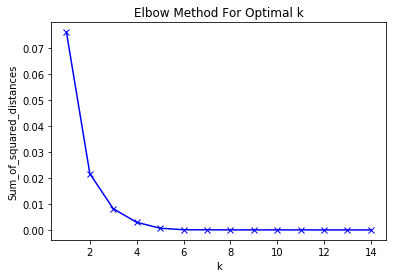

In [89]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Japanese Restaurants: k-Means clustering**

In [90]:
kjap = 3

kmeansjap = KMeans(n_clusters = kjap, random_state = 0).fit(jap_cluster)

kmeansjap.labels_[0:10]

array([2, 0, 2, 0, 2, 0, 2, 0, 0, 1])

**Japanese Restaurants: Add cluster label to dataframe**

In [92]:
dfjap["Cluster Label"] = kmeansjap.labels_
dfjap.head()

C:\Users\yuxii\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,MRT,Japanese Restaurants,Cluster Label
0,Admiralty,0.020408,2
1,Aljunied,0.000000,0
2,Ang Mo Kio,0.020000,2
3,Bartley,0.000000,0
4,Bayfront,0.040000,2


**Japanese Restaurants: Add Latitude and Longitude of MRT**

In [93]:
dfjap1 = dfjap.join(dfmrtlist.set_index("MRT"), on="MRT")
dfjap1.head()

,MRT,Japanese Restaurants,Cluster Label,Latitude,Longitude
0,Admiralty,0.020408,2,1.440690,103.800930
1,Aljunied,0.000000,0,1.329278,103.879562
2,Ang Mo Kio,0.020000,2,1.371610,103.845460
3,Bartley,0.000000,0,1.343927,103.875457
4,Bayfront,0.040000,2,1.281190,103.858730


**Japanese Restaurants: Visualise clusters**

In [97]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x1 = np.arange(kjap)
ys1 = [i+x1+(i*x1)**2 for i in range(kjap)]
colors_array1 = cm.rainbow(np.linspace(0, 1, len(ys1)))
rainbow1 = [colors.rgb2hex(i) for i in colors_array1]

# add markers to the map
markers_colors1 = []
for lat, lng, mrt, cluster in zip(dfjap1['Latitude'], dfjap1['Longitude'], dfjap1['MRT'], dfjap1['Cluster Label']):
    label1 = folium.Popup(str(mrt) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label1,
        color=rainbow1[cluster-1],
        fill=True,
        fill_color=rainbow1[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

**Japanese Restaurants: Study the clusters**

*Japanese Restaurants: Cluster 0*

In [99]:
dfjap1.loc[dfjap1['Cluster Label'] == 0]

,MRT,Japanese Restaurants,Cluster Label,Latitude,Longitude
1,Aljunied,0.0,0,1.329278,103.879562
3,Bartley,0.0,0,1.343927,103.875457
5,Beauty World,0.0,0,1.341430,103.775800
7,Bedok North,0.0,0,1.334450,103.918650
8,Bedok Reservoir,0.0,0,1.342610,103.925390
10,Bendemeer,0.0,0,1.320544,103.865187
12,Boon Keng,0.0,0,1.316286,103.863305
14,Botanic Gardens,0.0,0,1.315170,103.816380
19,Bukit Batok,0.0,0,1.349520,103.752770
20,Bukit Gombak,0.0,0,1.364170,103.757220


*Japanese Restaurants: Cluster 1*

In [100]:
dfjap1.loc[dfjap1['Cluster Label'] == 1]

,MRT,Japanese Restaurants,Cluster Label,Latitude,Longitude
9,Bencoolen,0.060000,1,1.301634,103.853344
35,Dover,0.060000,1,1.314370,103.893460
45,HarbourFront,0.100000,1,1.265200,103.820100
52,Jurong East,0.060000,1,1.334370,103.743670
65,Lorong Chuan,0.060000,1,1.361832,103.867934
75,Novena,0.060000,1,1.319100,103.843720
76,Orchard,0.060000,1,1.301090,103.839650
92,Simei,0.080000,1,1.342900,103.954350
94,Somerset,0.060000,1,1.302470,103.839170
96,Stevens,0.102041,1,1.312665,103.830969


*Japanese Restaurants: Cluster 2*

In [101]:
dfjap1.loc[dfjap1['Cluster Label'] == 2]

,MRT,Japanese Restaurants,Cluster Label,Latitude,Longitude
0,Admiralty,0.020408,2,1.440690,103.800930
2,Ang Mo Kio,0.020000,2,1.371610,103.845460
4,Bayfront,0.040000,2,1.281190,103.858730
6,Bedok,0.040816,2,1.324250,103.952970
11,Bishan,0.020000,2,1.350790,103.851100
13,Boon Lay,0.020408,2,1.333330,103.700000
15,Braddell,0.020408,2,1.343310,103.853573
16,Bras Basah,0.040816,2,1.296092,103.851782
17,Buangkok,0.040816,2,1.379888,103.893155
18,Bugis,0.040000,2,1.300810,103.855910
